In [1]:
import tensorflow as tf
#!/bin/bash -c "source /home/user/.bashrc"

%env TF_MODELS="/home/andreikvasov/repos/tensorflow/models"
#%env TF_MIN_GPU_MULTIPROCESSOR_COUNT=2

env: TF_MODELS="/home/andreikvasov/repos/tensorflow/models"


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import numpy
import pandas as pd
import tensorflow as tf
import time

import sys
# export PYTHONPATH=$PYTHONPATH:/home/andreikvasov/repos/tensorflow/models/research/slim
from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

#import argparse
import os

#from tensorflow.contrib.learn.python.learn.datasets import mnist

import tarfile
import gzip


# from six.moves import xrange  # pylint: disable=redefined-builtin
# from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes
# from tensorflow.python.framework import random_seed

In [3]:
multi_fov_dataset = '/home/andreikvasov/Documents/FOV/FOV_problem/'
write_tfread_to = multi_fov_dataset
multi_fov_dir=multi_fov_dataset

In [4]:
dataset_prefix = 'rpg_urban_'
#cam_type = 'pinhole'
#dir_path = os.path.join(write_tfread_to, dataset_prefix+cam_type)
#img_dir = os.path.join(dir_path, 'data')


img_w, img_h = 640, 480

# READ DATA from tar files

In [26]:
FLAGS = tf.flags.FLAGS

In [25]:
def read_data_sets(train_dir,
                   cam_types=[],
                   dtype=tf.uint8,
                   reshape=False,
                   write_tfread_to=multi_fov_dataset,
                   multi_fov_dir=multi_fov_dataset,
                   validation_size=0.25,
                   seed=None, make_dataset=False):
    
    images=[]
    for cam_type in cam_types:
        dir_path = os.path.join(write_tfread_to, dataset_prefix+cam_type)
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        # groundtruths and 
        filename = os.path.join(multi_fov_dir, dataset_prefix+cam_type+'_info.tar.gz')
        if not os.path.exists(filename):
            print('Please, download ' + cam_type + ' dataset! No pinhole extracted.')
            continue
        baz = tarfile.open(filename, 'r:gz')
        gt_txt = None
        with open(os.path.join(dir_path,'groundtruth.txt'), 'w') as f:
            f.write(baz.extractfile(baz.getmember('info/groundtruth.txt')).read())
        #print(dir_path + '/groundtruth.txt')
        gt_txt=pd.read_table(dir_path + '/groundtruth.txt', header=None, index_col=0, sep='\s+',
                            names=['image_id', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'])
        #print(gt_txt.shape)#, gt_txt.index.values, gt_txt.size)
        #print(gt_txt.iloc[-1])
        im_txt = None
        with open(os.path.join(dir_path,'images.txt'), 'w') as f:
            f.write(baz.extractfile(baz.getmember('info/images.txt')).read())  
        #print(dir_path + '/images.txt')
        im_txt=pd.read_table(dir_path + '/images.txt', header=None, index_col=0,sep='\s+',
                    names=['image_id', 'timestamp', 'path_to_img'])

        #print(im_txt.shape)#, im_txt.index.values)

        # image to tfread
        filename = os.path.join(multi_fov_dir, dataset_prefix+cam_type+'_data.tar.gz')
        baz = tarfile.open(filename, 'r:gz')
        if (not os.path.exists(os.path.join(dir_path, 'data/img'))):
            baz.extractall(dir_path)
        else:
            if not os.listdir(os.path.join(dir_path, 'data/img')): 
                baz.extractall(dir_path)
        #print(im_txt.shape, im_txt.index.values, im_txt.size)
        
    if not make_dataset:
        return
    
    images = np.concatenate(images, axis=0)
    gt_txt['timestamp'] = im_txt['timestamp']
    labels = gt_txt.values

    train_size = images.shape[0]
    if validation_size < 1:
        val_size = int(train_size*validation_size)
    else:
        if not 0 <= validation_size <= len(images):
            raise ValueError(
                'Validation size should be between 0 and {}. Received: {}.'
                .format(len(images), validation_size))
        val_size = int(validation_size)

    validation_images = images[:val_size]
    validation_labels = labels[:val_size]
    train_images = images[val_size:]
    train_labels = labels[val_size:]


    options = dict(dtype=dtype, reshape=reshape, seed=seed)

    train = DataSet(train_images, train_labels, **options)
    validation = DataSet(validation_images, validation_labels, **options)
    test = DataSet(images, labels, **options)

    return base.Datasets(train=train, validation=validation, test=test)

In [323]:
FLAGS.cam_types = ['pinhole']#, 'fisheye', 'cata']

In [324]:
read_data_sets(None, cam_types=FLAGS.cam_types,
                               dtype=tf.uint8,
                                reshape=False,
                               validation_size=0.25)

# Main

In [28]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz" # github models 
checkpoints_dir = multi_fov_dir

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

#Uncomment if to download pretrained net` 
if not os.path.exists(os.path.join(checkpoints_dir, url.split('/')[-1])):
    dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

In [5]:
import numpy as np
import os
import tensorflow as tf

#from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

from tensorflow.contrib import slim

from tensorflow.contrib.tensorboard.plugins import projector

In [6]:
cnt = 0
len_name = len('img0001_0.png')

image_size = vgg.vgg_16.default_image_size
filenames_list = []
cam_types = ['pinhole']#, 'fisheye', 'cata']
passing = [1]*3#, 5]
dataset_dir = os.path.join(multi_fov_dir, dataset_prefix+'_'.join(cam_types))
img_dir = os.path.join(multi_fov_dir, dataset_prefix+'_'.join(cam_types)+'/data/img')
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [386]:
filenames_list = []
gt_txt = None
for cam_type, step in zip(cam_types, passing):
    cur_filenames_list = []
    cur_img_dir = os.path.join(multi_fov_dir, dataset_prefix+cam_type+'/data/img')
    print(cur_img_dir)
    cur_filenames_list += [os.path.abspath(os.path.join(cur_img_dir, img_name)) 
                               for img_name in np.sort(os.listdir(cur_img_dir))
                               if 'png' in img_name and 'sprite' not in img_name and cam_type not in img_name ][::step]
    cur_dir = os.path.join(multi_fov_dir, dataset_prefix+cam_type)
    cur_gt_txt=pd.read_table(cur_dir + '/groundtruth.txt', header=None, index_col=0, sep='\s+',
                            names=['image_id', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'])
    cur_im_txt=pd.read_table(cur_dir + '/images.txt', header=None, index_col=0,sep='\s+',
                    names=['image_id', 'timestamp', 'path_to_img'])
    merged_txt = cur_gt_txt
    merged_txt['timestamp'] = cur_im_txt['timestamp']
    merged_txt['path_to_img'] = [cam_type + '_' + x[-len_name:] for x in cur_im_txt['path_to_img']]
    if gt_txt is None:
        gt_txt = merged_txt.iloc[::step]
    else:
        index = merged_txt.index
        names = 'image_id'
        index = (index.values + gt_txt.shape[0]).astype(np.int)
        merged_txt.index = pd.Index(index, names = names)
        gt_txt = pd.concat((gt_txt, merged_txt.iloc[::step]))

    for name in cur_filenames_list:
        new_name = os.path.join(img_dir, cam_type +'_'+name[-(len_name):])
        if not os.path.exists(new_name):
            os.system("cp '{0:}' '{1:}'".format(name, new_name))
        filenames_list += [new_name]

gt_txt.to_csv(os.path.join(dataset_dir, 'img_groundtruth.txt'), sep=' ', index_label='image_id',
          columns=[ 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw', 'timestamp', 'path_to_img'])

/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img


In [387]:
N = len(filenames_list)
D = 4096

FLAGS.batch_size = 25
FLAGS.min_queue_size = 1
FLAGS.num_examples = len(filenames_list)
FLAGS.num_threads = 2
FLAGS.num_epochs = 1

LOG_DIR = img_dir
print(N, filenames_list)

2500 ['/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0001_0.png', '/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0002_0.png', '/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0003_0.png', '/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0004_0.png', '/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0005_0.png', '/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0006_0.png', '/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0007_0.png', '/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0008_0.png', '/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0009_0.png', '/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/pinhole_img0010_0.png', '/home/andreikvasov/Docu

In [388]:
def read_my_file_format(filename_queue, sess):
    reader = tf.WholeFileReader()
    key, value = reader.read(filename_queue)
    #?tf.Print(key, [key])
    my_img = tf.image.decode_png(value, channels=3) # use png or jpg decoder based on your files
    processed_image = vgg_preprocessing.preprocess_image(my_img, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    #print(processed_images.shape)
    return processed_images, tf.constant([1], dtype=dtypes.int8)


def input_pipeline(filenames_list, batch_size=FLAGS.batch_size, 
                   read_threads=FLAGS.num_threads, num_epochs=None, shuffle=False,
                   session=None):
    filename_queue = tf.train.string_input_producer(
        filenames_list, pinholenum_epochs=num_epochs, shuffle=shuffle)
    example_list = [read_my_file_format(filename_queue, sess)
                  for _ in range(read_threads)]
    min_after_dequeue = FLAGS.min_queue_size #1000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch = tf.train.batch_join(
        example_list, batch_size=batch_size, capacity=capacity,
         enqueue_many=True, allow_smaller_final_batch=True) #min_after_dequeue=min_after_dequeue, #shapes=(1, image_size, image_size, 3)
    return example_batch, label_batch

# Tensorboard embedding visualization

In [340]:
import skimage.transform
from  scipy.misc import imresize, toimage

In [341]:
max_w = max_h = 8192 # max for tensorboard
w, h = 640//8, 480//8
N = len(filenames_list)
img_n_col_row = int(np.ceil(N**(1/2)))
sprite_image_shape = (h*img_n_col_row, w*img_n_col_row, 3)

In [342]:
sprite_image = np.empty(sprite_image_shape, dtype=np.float32)
print(sprite_image_shape)
assert sprite_image.shape[0] < max_h and sprite_image.shape[1] < max_w
i, j = 0, 0
filenames_list = np.sort(filenames_list).tolist()
for name in filenames_list:
    if j >= img_n_col_row:
        i, j = i+1, 0
        if not i % 10:
            print(i)
    assert i < img_n_col_row

    sprite_image[i*h:(i+1)*h, j*w:(j+1)*w] = skimage.transform.resize(plt.imread(name)[..., :3], (h, w, 3)) # imresize() analogue  
    j+=1

(3000, 4000, 3)
10
20
30
40


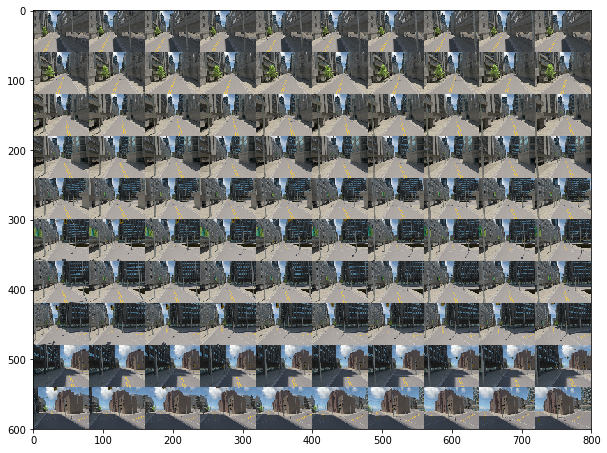

In [343]:
plt.figure(None, (10, 10))
plt.imshow(sprite_image[-h*10:, -w*10:][..., [0, 1, 2]])

In [344]:
# from PIL import Image
# _=Image.fromarray(sprite_image, mode='RGB')
print(os.path.join(img_dir, 'sprite_image.png'))
toimage(sprite_image, cmin=0.0, cmax=1).save(os.path.join(img_dir, 'sprite_image.png'))

/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img/sprite_image.png


/home/andreikvasov/.conda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  after removing the cwd from sys.path.


### Embedding evaluation

In [345]:
#tf.reset_default_graph() 
embeddings_1, embeddings_2, probabilities_l = [], [], []
D_1 = D_2 = 4096 # define dimensions of embedding layers you want to get.
with tf.Graph().as_default(): 
    sess = tf.Session()
    
    with slim.arg_scope(vgg.vgg_arg_scope()) as scope:

        cnt = 1
        example_images, labels =  input_pipeline(filenames_list, batch_size= FLAGS.batch_size, session=sess)
        logits, end_points = vgg.vgg_16(example_images, num_classes=1000, is_training=False) # define net architecture
        # print(end_points)
        embedding_1 = end_points['vgg_16/fc6'] # define embedding layer
        embedding_2 = end_points['vgg_16/fc7'] # define embedding layer
        #...
        probabilities = tf.nn.softmax(logits)

        #print('\n'.join(end_points.keys()))

        init_fn = slim.assign_from_checkpoint_fn(
            os.path.join(checkpoints_dir, 'vgg_16.ckpt'), # define checkpoint name
            slim.get_model_variables('vgg_16'))
        

    init_fn(sess)
    sess.run(tf.global_variables_initializer())
    
    #emb12 = sess.run([embedding_1, embedding_2, probabilities])

    # Start input enqueue threads.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    try:
#         threads = []
#         for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
#             threads.extend(qr.create_threads(sess, coord=coord, daemon=True,
#                                          start=True))
        num_iter = int(math.ceil(FLAGS.num_examples / FLAGS.batch_size))
        true_count = 0  # Counts the number of correct predictions.
        total_sample_count = num_iter * FLAGS.batch_size

        #sess.run(label_enqueue)
        step = 0
        while step < num_iter and not coord.should_stop():
#             end_epoch = False
#             if step > 0:
#                 for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
#                     #check if not enough elements in queue
#                     size = qr._queue.size().eval(session=sess)
#                     if size - FLAGS.batch_size < FLAGS.min_queue_size:
#                         end_epoch = True
#             if end_epoch:
#                 #enqueue more so that we can finish
#                 pass #sess.run(label_enqueue)
            #actually run step
            embedding_1_val, embedding_2_val, probabilities_val = sess.run([embedding_1, embedding_2, probabilities])
            #print(embedding_1_val, embedding_2_val, probabilities_val)
            embeddings_1 += [embedding_1_val.reshape(-1, D_1)] # D = 4096
            embeddings_2 += [embedding_2_val.reshape(-1, D_2)]
            #...
            probabilities_l += [probabilities_val[...,:5]]
            step += 1
            if not step % 10:
                print(step)
#               saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step)

    except tf.errors.OutOfRangeError:
        print('Done training for %d epochs, %d steps.' % (FLAGS.num_epochs, step))
    finally:
      # When done, ask the threads to stop.
      coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)
    sess.close()

INFO:tensorflow:Restoring parameters from /home/andreikvasov/Documents/FOV/FOV_problem/vgg_16.ckpt
10
20
30
40
50
60
70
80
90
100


In [ ]:
all_embeddings_1 = np.concatenate(embeddings_1, axis=0)
for x in (np.where(np.prod(np.isclose(emb, all_embeddings_1), axis=1))[0] for emb in all_embeddings_1):
    print(x)

In [ ]:
# If you take all pinhole, cata and fisheye, find whats the problem here?)

similar_files = np.array(filenames_list)[[199, 198]]
for i in similar_files:
    plt.figure()
    plt.imshow(plt.imread(i))

In [346]:
%store embeddings_1
%store embeddings_2

Stored 'embeddings_1' (list)
Stored 'embeddings_2' (list)


### Tensorboard projector and sprite load

In [7]:
%store -r embeddings_1
%store -r embeddings_2

In [348]:
with tf.Session() as sess:

    print("Start")
    N, D = len(filenames_list), 4096
    embedding_var_1 = tf.Variable(tf.random_normal([N, D]), name='image_embedding_vgg16_fc6')
    embedding_var_2 = tf.Variable(tf.random_normal([N, D]), name='image_embedding_vgg16_fc7')
    
    saver = tf.train.Saver([embedding_var_1, embedding_var_2])
    embedding_var_1.initializer.run()
    embedding_var_1.assign(np.concatenate(embeddings_1))
    
    embedding_var_2.initializer.run()
    embedding_var_2.assign(np.concatenate(embeddings_2))

    saver.save(sess, os.path.join(LOG_DIR, "embeddings_vars.ckpt"), 0)
    #saver_2.save(sess, os.path.join(LOG_DIR, "embeddings_var_2.ckpt"), 0)

    config = projector.ProjectorConfig()

    embedding_conf_1 = config.embeddings.add()
    embedding_conf_1.tensor_name = embedding_var_1.name
    
    embedding_conf_2 = config.embeddings.add()
    embedding_conf_2.tensor_name = embedding_var_2.name

    embedding_conf_1.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
    # Specify the width and height of a single thumbnail.
    embedding_conf_1.sprite.single_image_dim.extend([w, h])
    
    embedding_conf_2.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
    # Specify the width and height of a single thumbnail.
    embedding_conf_2.sprite.single_image_dim.extend([w, h])

    #print(embedding_var_1.eval(session=sess))
    summary_writer = tf.summary.FileWriter(LOG_DIR)


    projector.visualize_embeddings(summary_writer, config)
    print("End")


Start
End


In [8]:
all_embeddings_1 = np.concatenate(embeddings_1, axis=0)
all_embeddings_2 = np.concatenate(embeddings_2, axis=0)

In [9]:
img_dir

# Write in console: 
#tensorboard --logdir=[$img_dir] &

'/home/andreikvasov/Documents/FOV/FOV_problem/rpg_urban_pinhole/data/img'

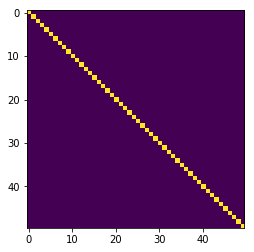

In [351]:
plt.imshow(np.prod(np.isclose(all_embeddings_1[np.newaxis, -50:, :], all_embeddings_1[-50:, np.newaxis, :]), axis=-1))

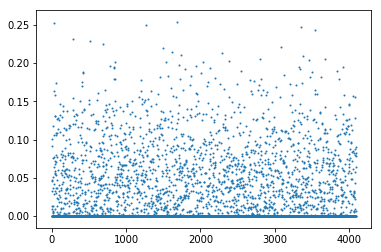

In [352]:
plt.figure()
plt.scatter(np.arange(all_embeddings_1.shape[1]), all_embeddings_1[0], s=1)

## Kernel nonpararmetric regression

In [77]:
from sklearn.decomposition import PCA

In [79]:
X_all = all_embeddings_1#[:200]
pca = PCA(n_components=6, random_state=0)
pca_emb_1 = pca.fit_transform(X_all)

pca_emb_1.shape

(2500, 6)

In [80]:
pca_emb = pca_emb_1
X_all = pca_emb
np.random.seed(100)
perm_ind = np.random.permutation(np.arange(pca_emb.shape[0]))
train_ind, test_ind = perm_ind[:int(pca_emb.shape[0]*0.7)], perm_ind[int(pca_emb.shape[0]*0.7):]

In [81]:
gt_txt = pd.read_table(os.path.join(dataset_dir, 'img_groundtruth.txt'), header='infer', index_col=0, sep='\s+')

In [82]:
y = gt_txt.loc[:, gt_txt.columns != 'path_to_img'].values
gt_txt

,tx,ty,tz,qx,qy,qz,qw,timestamp,path_to_img
image_id,,,,,,,,,
1,213.890121,-457.540314,6.400000,-0.706374,0.032181,-0.032183,0.706374,0.033333,pinhole_img0001_0.png
2,213.904694,-457.347473,6.399999,-0.706389,0.031867,-0.031870,0.706388,0.066667,pinhole_img0002_0.png
3,213.919235,-457.154663,6.399997,-0.706403,0.031554,-0.031556,0.706401,0.100000,pinhole_img0003_0.png
4,213.933777,-456.961823,6.399994,-0.706419,0.031240,-0.031243,0.706414,0.133333,pinhole_img0004_0.png
5,213.948318,-456.768951,6.399990,-0.706434,0.030927,-0.030929,0.706426,0.166667,pinhole_img0005_0.png
6,213.962860,-456.576111,6.399985,-0.706450,0.030614,-0.030616,0.706438,0.200000,pinhole_img0006_0.png
7,213.977402,-456.383240,6.399978,-0.706466,0.030301,-0.030303,0.706448,0.233333,pinhole_img0007_0.png
8,213.991959,-456.190338,6.399971,-0.706482,0.029988,-0.029990,0.706459,0.266667,pinhole_img0008_0.png
9,214.006470,-455.997528,6.399961,-0.706499,0.029675,-0.029677,0.706469,0.300000,pinhole_img0009_0.png


# Manual local nonparametric kernel regression

1) local linear / local constant

2) gaussian kernel / tri-cube

3) structured / unstructured kernel for standartisation of coordinates

In [83]:
def diag_cov(X):
    N, D = X.shape
    M = X.sum(axis=0)
    return np.diag(1/(N-1)*np.sum((X-M)*(X-M), axis=0))

In [84]:
def gaussian_structured_kernel(X, X0, A=None, h=None, Z = False):
    #h -  additional variance width to narrow gaussian domain (window)
    N0, D0 = X0.shape
    N, D = X.shape
    assert D0 == D
    nonz_var_ind = None
    if A is None:
        A = diag_cov(X)
        #A = np.eye(D)
        #A = np.cov(X, rowvar=False)
        nonz_var_ind = np.nonzero(np.diagonal(A))[0]
        A = np.diag(A[nonz_var_ind, nonz_var_ind])
        #print(A.shape)
    if Z:
        Z = ((2*np.pi)**D*np.linalg.det(A))**(-1/2.)
    else:
        Z = 1
    #print(A)
    #print((X[:, np.newaxis, :] - X0[np.newaxis, ...]).shape, A.shape, '\n', A, numpy.linalg.det(A))
    #print(np.tensordot(X[:, np.newaxis, :] - X0[np.newaxis, ...], np.linalg.inv(A), axes=(-1, 0)).shape) #+ lamb*np.eye(D)
    return  1/Z*np.exp(-np.sum(np.dot(
                                        X[:, np.newaxis, nonz_var_ind] - X0[np.newaxis, :, nonz_var_ind], np.linalg.inv(A))*
                                        (X[:, np.newaxis, nonz_var_ind] - X0[np.newaxis, : ,nonz_var_ind]), axis=-1)/
                       (2*h)), nonz_var_ind


tt = np.arange(30).reshape(5, 6)/10
t1 = np.arange(24).reshape(4, 6)/10# + np.random.normal(size=(5, 6))
#t1 = tt
s, _ = gaussian_structured_kernel(tt, t1, h=3*10**(-1))
print(s, np.sum(s))

[[ 1.          0.91643388  0.70534981  0.45594267]
 [ 0.91643388  1.          0.91643388  0.70534981]
 [ 0.70534981  0.91643388  1.          0.91643388]
 [ 0.45594267  0.70534981  0.91643388  1.        ]
 [ 0.24752451  0.45594267  0.70534981  0.91643388]] 15.557138729


In [85]:
def nadaraya_watson_knr(X, X0, y, K=None, h=1):
    if K is None:
        K,_ = gaussian_structured_kernel(X, X0, h=h)
    return np.dot(K.T, y)/np.sum(K.T, axis=1, keepdims=True)
    
def local_linear_knr(X, X0, y, K=None, h=1):
    if K is None:
        K, _ = gaussian_structured_kernel(X, X0, h=h)
    B = np.hstack((np.ones(shape=(X.shape[0], 1)), X))
    X0 = np.hstack((np.ones(shape=(X0.shape[0], 1)), X0))
    y0 = np.empty(shape=(X0.shape[0], y.shape[1]))
    cnt = 0
    for x0, w in zip(X0, K.T):
        #print(x0.reshape(-1, 1).shape)
        y0[cnt] = np.sum(x0.reshape(-1, 1)*
                         np.dot(np.linalg.inv(np.dot(B.T, w[:, np.newaxis]*B)), 
                                np.dot(B.T,w[:, np.newaxis]*y)), 
                         axis=0)
        cnt+=1
    return y0

In [86]:
h_list = np.logspace(-4, 1, num=50, base=10)
mse_list = []
for h in h_list:
    y0 = nadaraya_watson_knr(X_all[train_ind], X_all[test_ind], y[train_ind], h=h)
    mse_list += [np.mean((y0-y[test_ind])**2)]
    print(h, sep=' ')
h_list, mse_list = np.array(h_list), np.array(mse_list)

0.0001
0.000126485521686
0.000159985871961
0.000202358964773
0.00025595479227
0.000323745754282
0.000409491506238
0.000517947467923
0.00065512855686
0.000828642772855
0.00104811313415
0.00132571136559
0.00167683293681
0.00212095088792
0.00268269579528
0.0033932217719
0.00429193426013
0.00542867543932
0.00686648845004
0.00868511373751
0.0109854114199
0.0138949549437
0.0175751062485
0.0222299648253
0.0281176869797
0.0355648030622
0.0449843266897
0.0568986602902
0.0719685673001
0.0910298177992
0.115139539933
0.14563484775
0.184206996933
0.232995181052
0.294705170255
0.372759372031
0.471486636346
0.596362331659
0.754312006335
0.95409547635
1.20679264064
1.52641796718
1.93069772888
2.44205309455
3.08884359648
3.90693993705
4.94171336132
6.25055192527
7.90604321091
10.0


Text(0,0.5,u'mse')

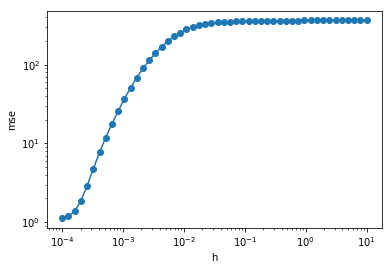

In [87]:
plt.loglog(h_list, mse_list, marker='o')
plt.xlabel('h')
plt.ylabel('mse')


In [88]:
mse_list_nnan = mse_list[~np.isnan(mse_list)]
h_list_nnan = h_list[~np.isnan(mse_list)]
h, ind = h_list_nnan[np.argmin(mse_list_nnan)], np.argmin(mse_list_nnan)
y0 = nadaraya_watson_knr(X_all[train_ind], X_all[test_ind], y[train_ind], h=h)
print("Minimal MSE ", np.mean((y0-y[test_ind])**2), " on h=", h)

Minimal MSE  1.12400297712  on h= 0.0001


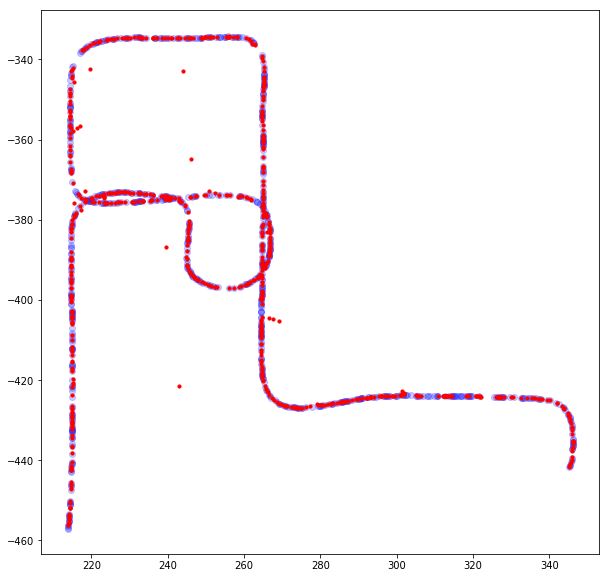

In [90]:
plt.figure(1,(10, 10))
N_obj = 2500
#for p, p0, c in zip(y[test_ind,:2][:30], y0[:,:2][:30], np.arange(30)/30):
#    plt.plot([p[0], p0[0]], [p[1], p0[1]],'k--',lw=0.5, color=str(c))
plt.scatter(y[test_ind,0][:N_obj], y[test_ind,1][:N_obj], c='b', alpha=0.2)
plt.scatter(y0[:,0][:N_obj], y0[:,1][:N_obj],c='r', s=10)
#plt.ylim((6, 7))

### Compare wiith local linear

In [56]:
h = 0.0449843266897
K, _ = gaussian_structured_kernel(X_all[train_ind], X_all[test_ind], h=h)

In [57]:
y0 = local_linear_knr(X_all[train_ind], X_all[test_ind], y[train_ind], h=h)
print("Minimal MSE ", np.mean((y0-y[test_ind])**2), " on h=", h)

Minimal MSE  3.35601470663  on h= 0.0449843266897


In [58]:
h_list = np.logspace(-3, 1, num=50, base=10)
mse_list = []
for h in h_list[::-1]:
    y0 = local_linear_knr(X_all[train_ind], X_all[test_ind], y[train_ind], h=h)
    mse_list = [np.mean((y0-y[test_ind])**2)] + mse_list
    print(h, sep=' ')
h_list, mse_list = np.array(h_list), np.array(mse_list)

10.0
8.28642772855
6.86648845004
5.68986602902
4.71486636346
3.90693993705
3.23745754282
2.68269579528
2.22299648253
1.84206996933
1.52641796718
1.26485521686
1.04811313415
0.868511373751
0.719685673001
0.596362331659
0.494171336132
0.409491506238
0.33932217719
0.281176869797
0.232995181052
0.193069772888
0.159985871961
0.132571136559
0.109854114199
0.0910298177992
0.0754312006335
0.0625055192527
0.0517947467923
0.0429193426013
0.0355648030622
0.0294705170255
0.0244205309455
0.0202358964773
0.0167683293681
0.0138949549437


LinAlgError: Singular matrix

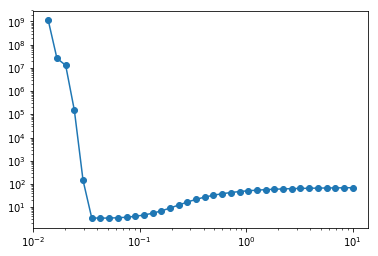

In [63]:
h_list, mse_list = np.array(h_list), np.array(mse_list)
h_list = h_list[-len(mse_list):]
plt.loglog(h_list, mse_list, marker='o')

In [64]:
mse_list_nnan = mse_list[~np.isnan(mse_list)]
h_list_nnan = h_list[~np.isnan(mse_list)]
h, ind = h_list_nnan[np.argmin(mse_list_nnan)], np.argmin(mse_list_nnan)
y0 = local_linear_knr(X_all[train_ind], X_all[test_ind], y[train_ind], h=h)
print("Minimal MSE ", np.mean((y0-y[test_ind])**2), " on h=", h)

Minimal MSE  3.35693392046  on h= 0.0429193426013


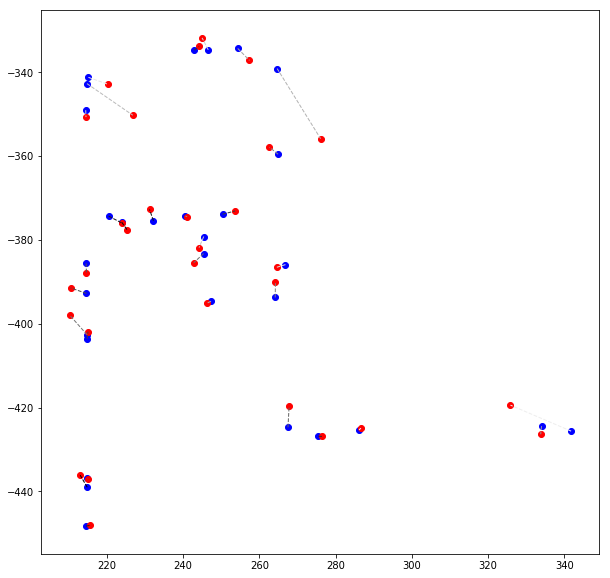

In [67]:
plt.figure(1,(10, 10))
for p, p0, c in zip(y[test_ind,:2][:30], y0[:,:2][:30], np.arange(30)/30):
    plt.plot([p[0], p0[0]], [p[1], p0[1]],'k--',lw=1, color=str(c))
plt.scatter(y[test_ind,0][:30], y[test_ind,1][:30], c='b')
plt.scatter(y0[:,0][:30], y0[:,1][:30],c='r')

In [ ]:
1) local linear error check
2) PCA-> manifold (nonlinear)
3) vgg16 -> less layers in 

# Optional for example and changes of everything up

### Inception example

In [ ]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
    """Creates the regression model.

    Args:
        inputs: A node that yields a `Tensor` of size [batch_size, dimensions].
        is_training: Whether or not we're currently training the model.
        scope: An optional variable_op scope for the model.

    Returns:
        predictions: 1-D `Tensor` of shape [batch_size] of responses.
        end_points: A dict of end points representing the hidden layers.
    """
    with tf.variable_scope(scope, 'deep_regression', [inputs]):
        end_points = {}
        # Set the default weight _regularizer and acvitation for each fully_connected layer.
        with slim.arg_scope([slim.fully_connected],
                            activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(0.01)):

            # Creates a fully connected layer from the inputs with 32 hidden units.
            net = slim.fully_connected(inputs, 32, scope='fc1')
            end_points['fc1'] = net

            # Adds a dropout layer to prevent over-fitting.
            net = slim.dropout(net, 0.8, is_training=is_training)

            # Adds another fully connected layer with 16 hidden units.
            net = slim.fully_connected(net, 16, scope='fc2')
            end_points['fc2'] = net

            # Creates a fully-connected layer with a single hidden unit. Note that the
            # layer is made linear by setting activation_fn=None.
            predictions = slim.fully_connected(net, 1, activation_fn=None, scope='prediction')
            end_points['out'] = predictions

            return predictions, end_points

In [ ]:
with tf.Graph().as_default():
    # Dummy placeholders for arbitrary number of 1d inputs and outputs
    inputs = tf.placeholder(tf.float32, shape=(None, 1))
    outputs = tf.placeholder(tf.float32, shape=(None, 1))

    # Build model
    predictions, end_points = regression_model(inputs)

    # Print name and shape of each tensor.
    print("Layers")
    for k, v in end_points.items():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

    # Print name and shape of parameter nodes  (values not yet initialized)
    print("\n")
    print("Parameters")
    for v in slim.get_model_variables():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

In [ ]:
def produce_batch(batch_size, noise=0.3):
    xs = np.random.random(size=[batch_size, 1]) * 10
    ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
    return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)

In [ ]:
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

In [ ]:
# The following snippet trains the regression model using a mean_squared_error loss.
ckpt_dir = '/tmp/regression_model/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    inputs, targets = convert_data_to_tensors(x_train, y_train)

    # Make the model.
    predictions, nodes = regression_model(inputs, is_training=True)

    # Add the loss function to the graph.
    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    # The total loss is the uers's loss plus any regularization losses.
    total_loss = tf.losses.get_total_loss()

    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
    train_op = slim.learning.create_train_op(total_loss, optimizer) 

    # Run the training inside a session.
    final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=5000,
        save_summaries_secs=5,
        log_every_n_steps=500)
  
print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

In [ ]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
  
    # Create the model structure. (Parameters will be loaded below.)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, targets = sess.run([inputs, predictions, targets])

plt.scatter(inputs, targets, c='r');
plt.scatter(inputs, predictions, c='b');
plt.title('red=true, blue=predicted')

In [ ]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Specify metrics to evaluate:
    names_to_value_nodes, names_to_update_nodes = slim.metrics.aggregate_metric_map({
      'Mean Squared Error': slim.metrics.streaming_mean_squared_error(predictions, targets),
      'Mean Absolute Error': slim.metrics.streaming_mean_absolute_error(predictions, targets)
    })

    # Make a session which restores the old graph parameters, and then run eval.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        metric_values = slim.evaluation.evaluation_loop(
            '',ckpt_dir,None,
            num_evals=1, # Single pass over data
            eval_op=names_to_update_nodes.values(),
            final_op=names_to_value_nodes.values())

    names_to_values = dict(zip(names_to_value_nodes.keys(), metric_values))
    for key, value in names_to_values.items():
      print('%s: %f' % (key, value))

In [ ]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir)


In [ ]:
dataset.data_sources

In [ ]:
from datasets import flowers
import tensorflow as tf

from tensorflow.contrib import slim

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

In [ ]:
def my_cnn(images, num_classes, is_training):  # is_training is not used...
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
        return net

In [ ]:
import tensorflow as tf

with tf.Graph().as_default():
    # The model can handle any input size because the first layer is convolutional.
    # The size of the model is determined when image_node is first passed into the my_cnn function.
    # Once the variables are initialized, the size of all the weight matrices is fixed.
    # Because of the fully connected layers, this means that all subsequent images must have the same
    # input size as the first image.
    batch_size, height, width, channels = 3, 28, 28, 3
    images = tf.random_uniform([batch_size, height, width, channels], maxval=1)
    
    # Create the model.
    num_classes = 10
    logits = my_cnn(images, num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
  
    # Initialize all the variables (including parameters) randomly.
    init_op = tf.global_variables_initializer()
  
    with tf.Session() as sess:
        # Run the init_op, evaluate the model outputs and print the results:
        sess.run(init_op)
        probabilities = sess.run(probabilities)
        
print('Probabilities Shape:')
print(probabilities.shape)  # batch_size x num_classes 

print('\nProbabilities:')
print(probabilities)

print('\nSumming across all classes (Should equal 1):')
print(np.sum(probabilities, 1)) # Each row sums to 1

In [ ]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [ ]:
from datasets import flowers

# This might take a few minutes.
train_dir = '/tmp/tfslim_model/'
print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, batch_size=10)
  
    # Create the model:
    logits = my_cnn(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    tf.losses.softmax_cross_entropy(one_hot_labels, logits)
    total_loss = tf.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=1, # For speed, we just do 1 epoch
      save_summaries_secs=1)
  
    print('Finished training. Final batch loss %d' % final_loss)

In [ ]:
from datasets import flowers

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = my_cnn(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/Recall@5': slim.metrics.streaming_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=names_to_updates.values(),
        final_op=names_to_values.values())

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))

# READ DATA

In [61]:
FLAGS.cam_types = ['cata', 'fisheye']

In [62]:
read_data_sets(None, cam_types=FLAGS.cam_types,
                               dtype=tf.uint8,
                                reshape=False,
                               validation_size=0.25)

/home/andreikvasov/Documents/term4_research/multi_fov_dataset/rpg_urban_cata/groundtruth.txt
(2500, 7)
/home/andreikvasov/Documents/term4_research/multi_fov_dataset/rpg_urban_cata/images.txt
(2500, 2)
(2500, 2) [   1    2    3 ..., 2498 2499 2500] 5000
/home/andreikvasov/Documents/term4_research/multi_fov_dataset/rpg_urban_fisheye/groundtruth.txt
(2500, 7)
/home/andreikvasov/Documents/term4_research/multi_fov_dataset/rpg_urban_fisheye/images.txt
(2500, 2)
(2500, 2) [   1    2    3 ..., 2498 2499 2500] 5000


In [ ]:
class DataSet(object):
  import numpy

  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True,
               seed=None):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.  Seed arg provides for convenient deterministic testing.
    """
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    numpy.random.seed(seed1 if seed is None else seed2)
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if reshape:
        assert images.shape[3] == 1
        images = images.reshape(images.shape[0],
                                images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False, shuffle=True):
    """Return the next `batch_size` examples from this data set."""
#     if fake_data:
#       fake_image = [1] * 784
#       if self.one_hot:
#         fake_label = [1] + [0] * 9
#       else:
#         fake_label = 0
#       return [fake_image for _ in xrange(batch_size)], [
#           fake_label for _ in xrange(batch_size)
#       ]
    start = self._index_in_epoch
    # Shuffle for the first epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm0)
      self._images = self.images[perm0]
      self._labels = self.labels[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._images[start:self._num_examples]
      labels_rest_part = self._labels[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = numpy.arange(self._num_examples)
        numpy.random.shuffle(perm)
        self._images = self.images[perm]
        self._labels = self.labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._images[start:end]
      labels_new_part = self._labels[start:end]
      return numpy.concatenate((images_rest_part, images_new_part), axis=0) , numpy.concatenate((labels_rest_part, labels_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self._images[start:end], self._labels[start:end]

In [ ]:
FLAGS = None


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_to(data_set, name):
    """Converts a dataset to tfrecords."""
    images = data_set.images
    labels = data_set.labels
    num_examples = data_set.num_examples

    if images.shape[0] != num_examples:
        raise ValueError('Images size %d does not match label size %d.' %
                         (images.shape[0], num_examples))
    rows = images.shape[1]
    cols = images.shape[2]
    depth = images.shape[3]

    filename = os.path.join(FLAGS.directory, name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(num_examples):
        image_raw = images[index].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(rows),
            'width': _int64_feature(cols),
            'depth': _int64_feature(depth),
            'label': _float_feature(labels[index]),
            'image_raw': _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())
    writer.close()


def main(unused_argv):
    # Get the data.
    data_sets = read_data_sets(FLAGS.directory, cam_types=FLAGS.cam_types,
                               dtype=tf.uint8,
                                reshape=False,
                               validation_size=0.25)

    # Convert to Examples and write the result to TFRecords.
    convert_to(data_sets.train, 'train')
    convert_to(data_sets.validation, 'validation')
    convert_to(data_sets.test, 'test')


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#       '--directory',
#       type=str,
#       default='/tmp/data',
#       help='Directory to download data files and write the converted result'
#     )
#     parser.add_argument(
#       '--validation_size',
#       type=int,
#       default=5000,
#       help="""\
#       Number of examples to separate from the training data for the validation
#       set.\
#       """
#     )
#FLAGS, unparsed = parser.parse_known_args()
#     print(FLAGS, unparsed)
FLAGS=argparse.Namespace(directory="/home/user/kvasov/multi_fov_dataset/rpg_urban_pinhole", cam_types=['pinhole'])
tf.app.run(main=main, argv=[sys.argv[0]])# + unparsed)